In [124]:
!pip install statsmodels

     |████████████████████████████████| 9.4 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 17.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [149]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import Markdown, display


def printmd(string):
    display(Markdown(string))


%matplotlib inline
sns.set_style("darkgrid")
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Generate a time-series data

In [71]:
time = np.arange(1200, dtype="float32")
baseline = 0


def trend(time, slope, intercept=0):
    """Add trend to the data"""
    return time * slope + intercept


def seasonality(time, period, offset=0):
    """Add seasonality to the data"""
    season_time = (time + offset) % period
    return np.where(
        season_time / period < 0.5,
        np.cos(season_time / period * 2 * np.pi) - 10,
        -1 / 3 * season_time + 10,
    )


def noise(time, amplitude, seed=42):
    """Add noise to the data"""
    rnd = np.random.RandomState(seed=seed)
    return rnd.randn(len(time)) * amplitude

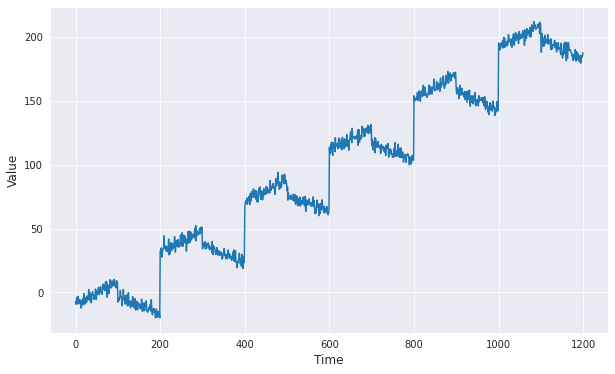

In [72]:
ts = seasonality(time, 200) + trend(time, 0.2) + noise(time, 3)
plt.figure(figsize=(10, 6))
plt.plot(time, ts)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.show()

## Training and validation split

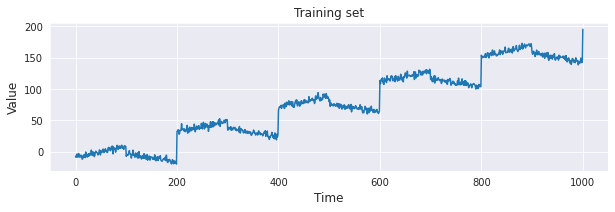

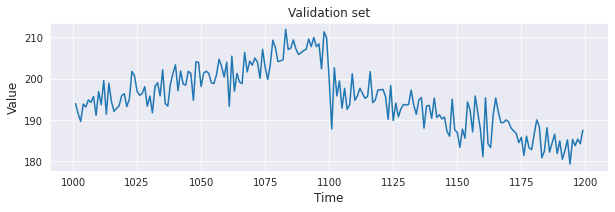

In [74]:
split_time = 1000 + 1
trn = ts[:split_time]
val = ts[split_time:]

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time[:split_time], trn)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Training set")
plt.show()
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 2)
plt.plot(time[split_time:], val)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Validation set")
plt.show()

## Naive prediction

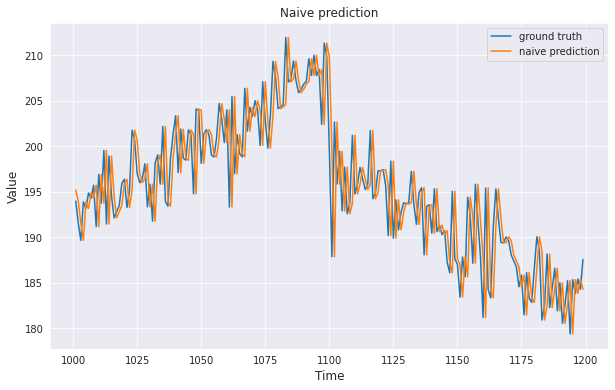

In [91]:
np = ts[split_time - 1 : -1]

plt.figure(figsize=(10, 6))
plt.plot(time[split_time:], val, label="ground truth")
plt.plot(time[split_time:], np, label="naive prediction")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Naive prediction")
plt.legend()
plt.show()

### Check the loss

In [101]:
printmd(f"#### Mean squared error: {round(mean_squared_error(val, np),3)}")
printmd(f"#### Mean absolute error: {round(mean_absolute_error(val, np),3)}")

#### Mean squared error: 21.093

#### Mean absolute error: 3.543

## Moving average 

In [144]:
def moving_average(ts, window_size):
    ma = []
    for i in range(len(ts) - window_size):
        ma.append(ts[i : i + window_size].mean())
    return ma


def moving_average_forcast(ts, window_size, nof_value):
    for i in range(nof_value):
        ts = np.append(ts, ts[-window_size:].mean())
    return ts

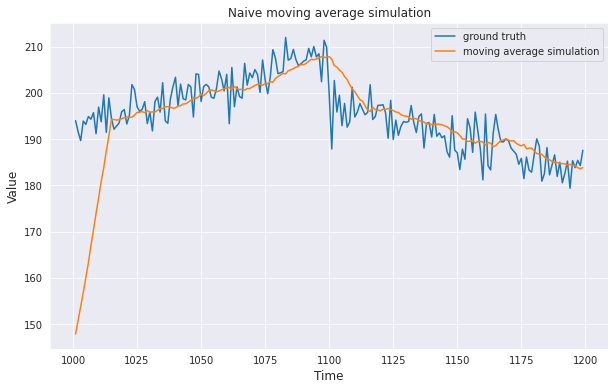

In [134]:
window_size = 15
ma = moving_average(ts, window_size)
plt.figure(figsize=(10, 6))
plt.plot(time[split_time:], val, label="ground truth")
plt.plot(
    time[split_time:], ma[split_time - window_size :], label="moving average simulation"
)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Naive moving average simulation")
plt.legend()
plt.show()

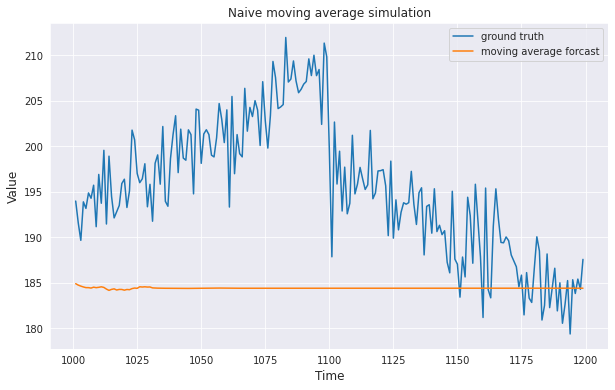

In [142]:
window_size = 30
# ma = moving_average(ts, window_size)
map_ = moving_average_forcast(ts, window_size, 199)
plt.figure(figsize=(10, 6))
plt.plot(time[split_time:], val, label="ground truth")
plt.plot(time[split_time:], map_[-199:], label="moving average forcast")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Naive moving average simulation")
plt.legend()
plt.show()

## Stationality test

In [153]:
from statsmodels.tsa.stattools import adfuller


def test_stationarity(timeseries, window=12):
    rolmean = timeseries.rolling(window=window, center=False).mean()
    rolstd = timeseries.rolling(window=window, center=False).std()
    plt.figure(figsize=(10, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")  # 设置原始图，移动平均图和标准差图的式样
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")  # 使用自动最佳的图例显示位置
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()  # 供肉眼观察是否平稳
    print("ADF检验结果：")
    dftest = adfuller(timeseries, autolag="AIC")  # 使用减小AIC的办法估算ADF测试所需的滞后数
    # 将ADF测试结果、显著性概率、所用的滞后数和所用的观测数打印出来
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Num Lags Used", "Num Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

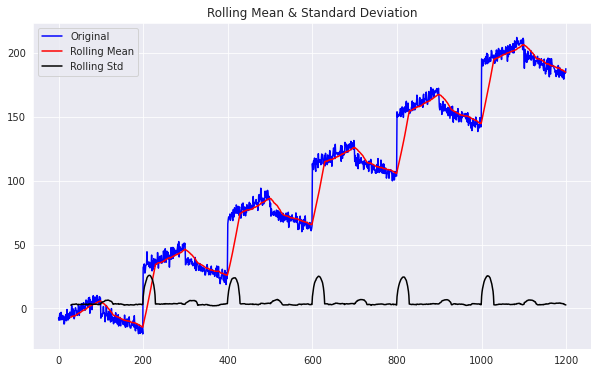

ADF检验结果：
Test Statistic             -0.984565
p-value                     0.758852
Num Lags Used               2.000000
Num Observations Used    1197.000000
Critical Value (1%)        -3.435825
Critical Value (5%)        -2.863958
Critical Value (10%)       -2.568057
dtype: float64


In [159]:
ts_df = pd.DataFrame()
ts_df["ts"] = ts
test_stationarity(ts_df["ts"], window=30)